In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# Change path accordingly if data is saved in your Drive
zip_path1 = '/content/gdrive/MyDrive/CV_3/TrainIJCNN2013.zip'
zip_path2 = '/content/gdrive/MyDrive/CV_3/TestIJCNN2013.zip'

Mounted at /content/gdrive


In [ ]:
import os
import zipfile

# # Uncomment zip_path, if data is saved locally
# zip_path1 = '/content/TestIJCNN2013.zip'

zip_ref = zipfile.ZipFile(zip_path1, 'r')
zip_ref.extractall('/content')
zip_ref.close()

# # Uncomment zip_path, if data is saved locally
# local_zip2 = '/content/TrainIJCNN2013.zip'

zip_ref = zipfile.ZipFile(zip_path2, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import numpy as np
import cv2

train_dir = 'TrainIJCNN2013'

train_files = os.listdir(train_dir)

file_max_dim = []
file_aspect_ratio = []
for file in train_files:
  path = os.path.join(train_dir, file)
  if (not os.path.isfile(path)) or file.endswith('.txt'):
    continue
  img_shape = (cv2.imread(path)).shape
  file_max_dim.append(max(img_shape))
  file_aspect_ratio.append(img_shape[1]/img_shape[0])


total_files = len(file_max_dim)
train_dim = round((sum(file_max_dim)/total_files))
train_aspect_ratio = sum(file_aspect_ratio)/total_files

print("The average (max) dimension in train (and validation) data is: %d" % train_dim)
print("The average aspect ratio in train (and validation) data is: %.2f" % train_aspect_ratio)

The average (max) dimension in train (and validation) data is: 1360
The average aspect ratio in train (and validation) data is: 1.70


Plot a train image to ensure successful operation:



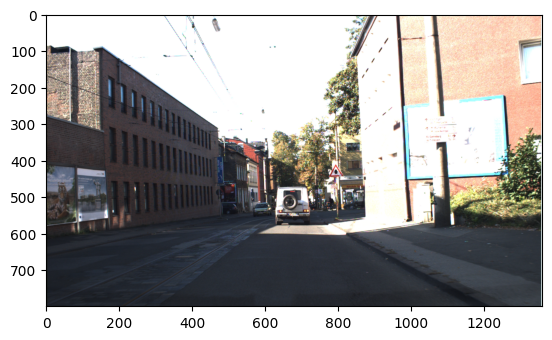


Plot a test image to ensure successful operation:



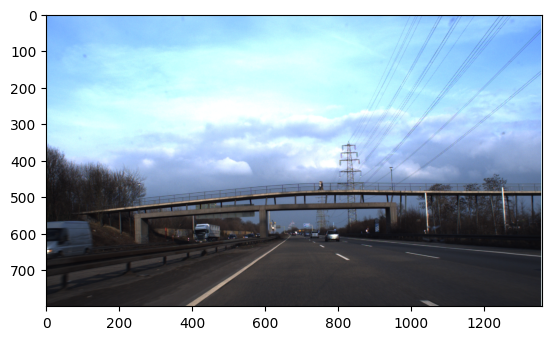

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = 'TrainIJCNN2013/00000.ppm'
img = mpimg.imread(img_path)
plt.imshow(img)

print("Plot a train image to ensure successful operation:")
print()
plt.show()

img_path = 'TestIJCNN2013Download/00000.ppm'
img = mpimg.imread(img_path)
plt.imshow(img)

print()
print("Plot a test image to ensure successful operation:")
print()
plt.show()

In [ ]:
import torch
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from PIL import Image
import pandas as pd
import csv

# Class name to integer mapping
CLASS_NAME_TO_ID = {"Background" : 43}
for i in range(43):
  CLASS_NAME_TO_ID[str(i)] = i

def convert_to_CSV_and_split(txt_file, image_dir):

    csv_file = os.path.join(image_dir,"_annotations.csv")

    with open(txt_file, 'r') as in_file:
        stripped = (line.strip() for line in in_file)
        lines = (line.split(";") for line in stripped if line)
        with open(csv_file, 'w') as out_file:
            writer = csv.writer(out_file)
            writer.writerow(('filename', 'xleft','ytop','xright','ybottom','class_id'))
            writer.writerows(lines)

    # Read CSV file
    df = pd.read_csv(csv_file)

    unique_filenames = df["filename"].unique()
    # Split the dataset: 90% for training, 10% for validation
    train_filenames, val_filenames = train_test_split(unique_filenames, test_size=0.1, random_state=None)

    train_df = df[df["filename"].isin(train_filenames)]
    val_df = df[df["filename"].isin(val_filenames)]

    # Save the new train and validation sets to CSV files
    train_csv = os.path.join(image_dir,"train_annotations.csv")
    val_csv = os.path.join(image_dir,"valid_annotations.csv")

    train_df.to_csv(train_csv, index=False)
    val_df.to_csv(val_csv, index=False)

class IJCNN2013Dataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, label_file, transforms=None):
        self.image_dir = image_dir
        self.transforms = transforms
        self.annotations = []

        # Load annotations
        with open(label_file, "r") as f:
            for line_no, line in enumerate(f.readlines()):
                if line_no == 0:  # Skip header row
                    continue
                # Extract columns
                fields = line.strip().split(",")
                if len(fields) != 6:  # Ensure all 6 columns are present
                    print(f"Skipping malformed line {line_no + 1}: {line.strip()}")
                    continue

                filename, xleft, ytop, xright, ybottom, class_name = fields
                xleft, ytop, xright, ybottom = float(xleft), float(ytop), float(xright), float(ybottom)

                # Skip invalid boxes where width or height is zero
                if xleft >= xright or ytop >= ybottom:
                    print(f"Skipping invalid bounding box at line {line_no + 1}: [{xleft}, {ytop}, {xright}, {ybottom}]")
                    continue

                self.annotations.append({
                    "filename": filename,
                    "bbox": [xleft, ytop, xright, ybottom],
                    "label": CLASS_NAME_TO_ID[class_name]
                })

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        annotation = self.annotations[idx]
        img_path = os.path.join(self.image_dir, annotation["filename"])
        img = Image.open(img_path).convert("RGB")

        # Convert bounding box and label to tensors
        boxes = torch.tensor([annotation["bbox"]], dtype=torch.float32)
        labels = torch.tensor([annotation["label"]], dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels}

        # Apply transforms if provided
        if self.transforms:
            img = self.transforms(img)

        return img, target


# Define transforms
transforms = T.Compose([
    T.ToTensor(),
    T.Resize((800, 1360))
])

# Load the dataset
convert_to_CSV_and_split("TrainIJCNN2013/gt.txt", "TrainIJCNN2013")
train_dataset = IJCNN2013Dataset("TrainIJCNN2013", "TrainIJCNN2013/train_annotations.csv", transforms=transforms)
val_dataset = IJCNN2013Dataset("TrainIJCNN2013", "TrainIJCNN2013/valid_annotations.csv", transforms=transforms)

# train_size = round((1-val_ratio) * len(train_dataset))
# val_size = len(train_dataset) - train_size

# train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Example: Access a sample
img, target = train_dataset[0]
print("Image shape:", img.shape)
print("Bounding boxes:", target["boxes"])
print("Labels:", target["labels"])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


Image shape: torch.Size([3, 800, 1360])
Bounding boxes: tensor([[774., 411., 815., 446.]])
Labels: tensor([11])


In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Load pre-trained Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Modify the classifier for IJCNN2013 dataset
num_classes = 44  # 43 + 1 (background)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 185MB/s]


In [ ]:
import torch
import torch.optim as optim
from torchvision.ops import box_iou
import time

def calculate_map(pred_boxes, pred_scores, gt_boxes, iou_threshold=0.5):
    """
    Calculate mAP for a batch of predictions and ground truths.
    """
    tp = 0
    fp = 0
    total_gt = len(gt_boxes)

    # Sort predictions by confidence (highest confidence first)
    sorted_indices = torch.argsort(pred_scores, descending=True)
    pred_boxes = pred_boxes[sorted_indices]

    matched_gt = set()

    for i, pred_box in enumerate(pred_boxes):
        best_iou = 0
        best_gt_idx = -1

        # Match with ground truth boxes
        for j, gt_box in enumerate(gt_boxes):
            if j in matched_gt:
                continue
            iou = box_iou(pred_box.unsqueeze(0), gt_box.unsqueeze(0)).item()
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = j

        if best_iou > iou_threshold:
            tp += 1
            matched_gt.add(best_gt_idx)
        else:
            fp += 1

    precision = tp / (tp + fp + 1e-6)
    recall = tp / total_gt
    return precision, recall

def train_model_with_map(model, train_loader, val_loader, device, num_epochs=10, lr=1e-4):
    """
    Train a Faster R-CNN model with mAP calculation and verbose outputs.

    Args:
    - model: PyTorch Faster R-CNN model.
    - train_loader: DataLoader for training set.
    - val_loader: DataLoader for validation set.
    - device: 'cuda' or 'cpu'.
    - num_epochs: Number of epochs.
    - lr: Learning rate.
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print("-" * 50)

        # Training phase
        model.train()
        epoch_loss = 0
        for batch_idx, (images, targets) in enumerate(train_loader):
          # if batch_idx>3:
            # continue
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Forward and compute loss
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            epoch_loss += losses.item()

            # Backward
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            if (batch_idx + 1) % 10 == 0:
                print(f"Batch [{batch_idx + 1}/{len(train_loader)}] - Loss: {losses.item():.4f}")

        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch [{epoch + 1}] - Average Loss: {avg_loss:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, targets in val_loader:
                images = [img.to(device) for img in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                # Forward pass to get predictions
                outputs = model(images)

                # Note: Skipping loss calculation in eval mode
                for i, output in enumerate(outputs):
                    print(f"Validation Batch - Image {i+1}: Predicted {len(output['boxes'])} boxes")

        print(f"Epoch [{epoch + 1}] - Validation Done.")

    print("\nTraining Complete!")
    return model

In [ ]:
# Initialize the model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 44  # 43 + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train the model
trained_model = train_model_with_map(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    num_epochs=15,
    lr=1e-4
)

# Save the trained model
torch.save(trained_model.state_dict(), "faster_rcnn_IJCNN2013_with_map.pth")
print()
print()
print("### Model saved successfully as faster_rcnn_IJCNN2013_with_map.pth ###")



Epoch 1/15
--------------------------------------------------
Batch [10/48] - Loss: 0.2925
Batch [20/48] - Loss: 0.2947
Batch [30/48] - Loss: 0.3258
Batch [40/48] - Loss: 0.3098
Epoch [1] - Average Loss: 0.4613
Validation Batch - Image 1: Predicted 4 boxes
Validation Batch - Image 2: Predicted 1 boxes
Validation Batch - Image 3: Predicted 1 boxes
Validation Batch - Image 4: Predicted 1 boxes
Validation Batch - Image 5: Predicted 1 boxes
Validation Batch - Image 6: Predicted 1 boxes
Validation Batch - Image 7: Predicted 1 boxes
Validation Batch - Image 8: Predicted 1 boxes
Validation Batch - Image 9: Predicted 1 boxes
Validation Batch - Image 10: Predicted 0 boxes
Validation Batch - Image 11: Predicted 0 boxes
Validation Batch - Image 12: Predicted 3 boxes
Validation Batch - Image 13: Predicted 3 boxes
Validation Batch - Image 14: Predicted 2 boxes
Validation Batch - Image 15: Predicted 2 boxes
Validation Batch - Image 16: Predicted 1 boxes
Validation Batch - Image 1: Predicted 3 boxes

In [ ]:
# Initialize the model architecture
num_classes = 44  # 43 + background
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load trained weights
model.load_state_dict(torch.load("faster_rcnn_IJCNN2013_with_map.pth"))
model.eval()  # Set to evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 184MB/s]
<ipython-input-10-da88194b5eaa>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpi

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [ ]:
# Map class IDs to class names
ID_TO_CLASS_NAME = {43 : "Background"}
for i in range(0,43):
  ID_TO_CLASS_NAME[i] = str(i)

def visualize_predictions(image_path, model, threshold=0.5):
    """
    Visualize predictions on a single image.

    Args:
    - image_path: Path to the input image.
    - model: Trained Faster R-CNN model.
    - threshold: Confidence threshold for displaying predictions.
    """
    # Load and preprocess the image
    img = Image.open(image_path).convert("RGB")
    transform = T.Compose([T.ToTensor()])
    img_tensor = transform(img).to(device)

    # Make predictions
    with torch.no_grad():
        prediction = model([img_tensor])

    # Extract boxes, labels, and scores
    pred_boxes = prediction[0]['boxes'].cpu().numpy()
    pred_scores = prediction[0]['scores'].cpu().numpy()
    pred_labels = prediction[0]['labels'].cpu().numpy()

    # Draw boxes on the original image
    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    for box, score, label in zip(pred_boxes, pred_scores, pred_labels):
        if score >= threshold:
            x1, y1, x2, y2 = box.astype(int)
            class_name = ID_TO_CLASS_NAME[label]

            # Draw rectangle and label
            cv2.rectangle(img_cv, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img_cv, f"{class_name}: {score:.2f}", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


Visualizing predictions for: 00177.ppm



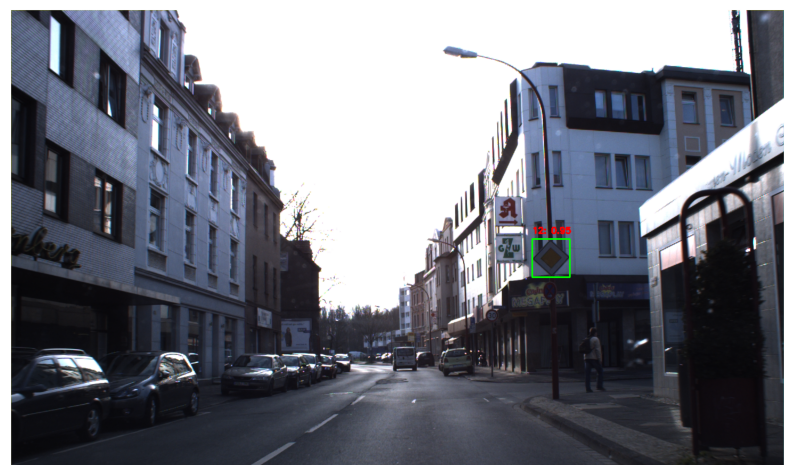


Visualizing predictions for: 00262.ppm



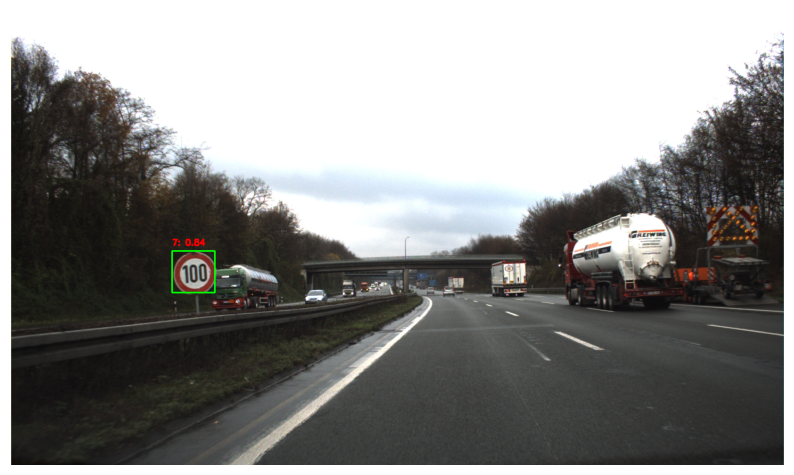


Visualizing predictions for: 00059.ppm



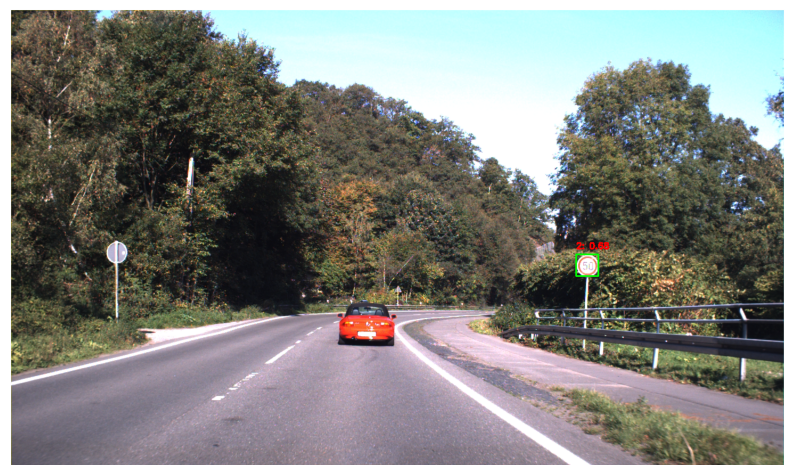


Visualizing predictions for: 00179.ppm



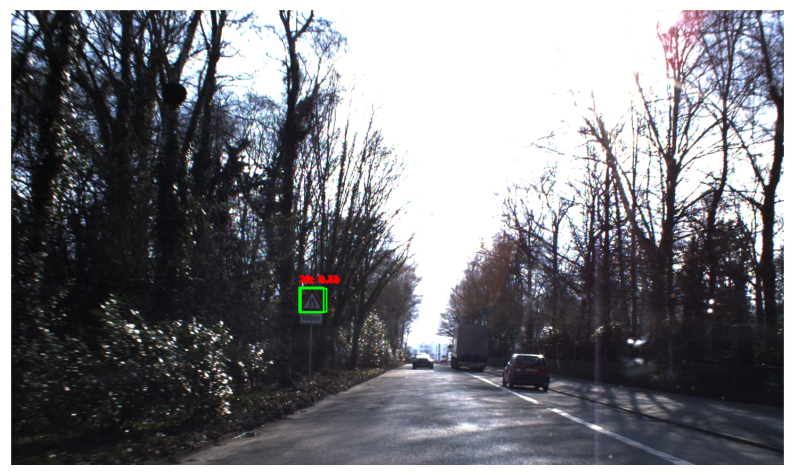


Visualizing predictions for: 00057.ppm



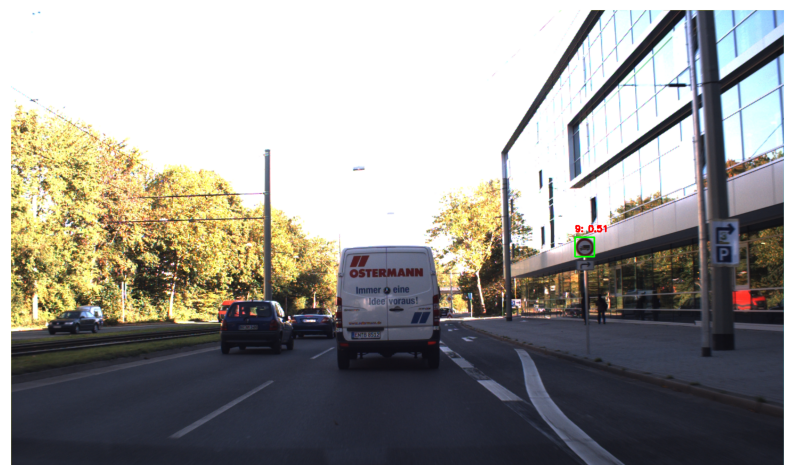


Visualizing predictions for: 00213.ppm



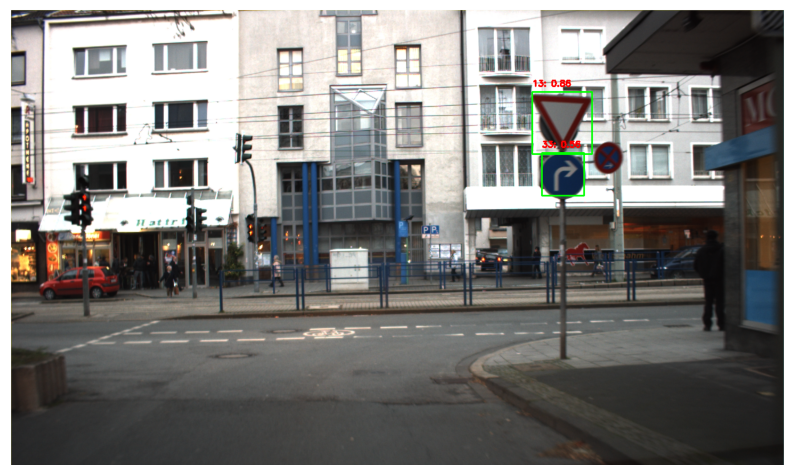


Visualizing predictions for: 00031.ppm



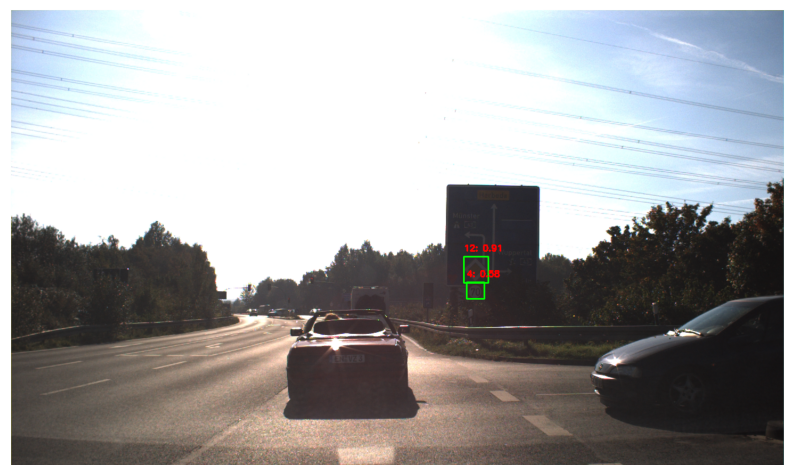


Visualizing predictions for: 00289.ppm



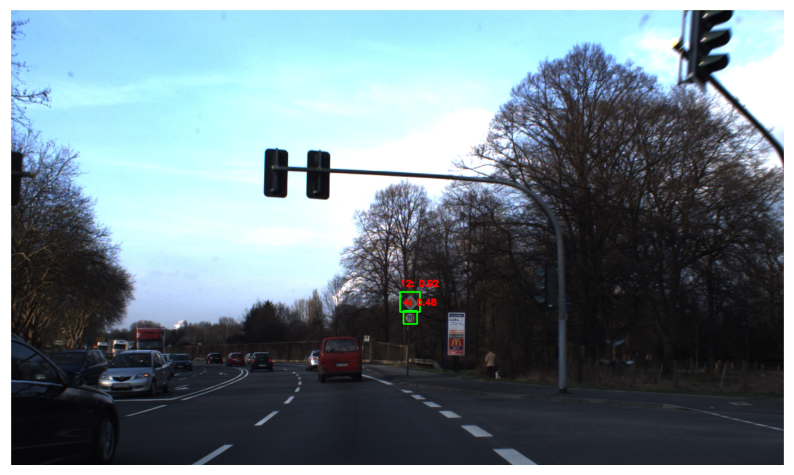


Visualizing predictions for: 00011.ppm



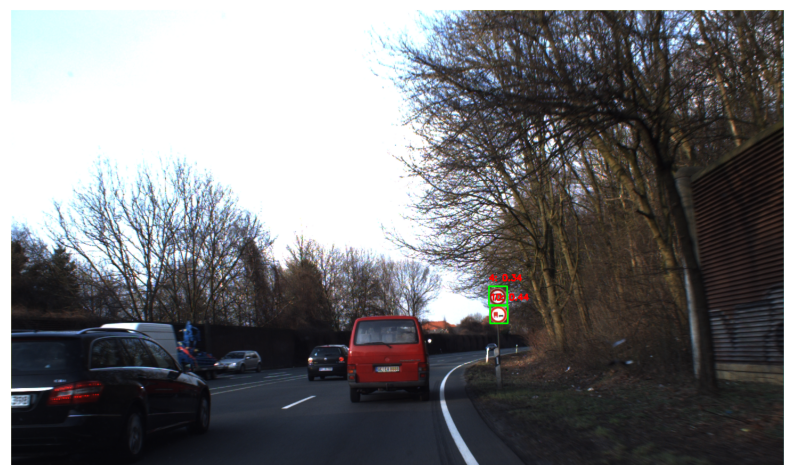


Visualizing predictions for: 00246.ppm



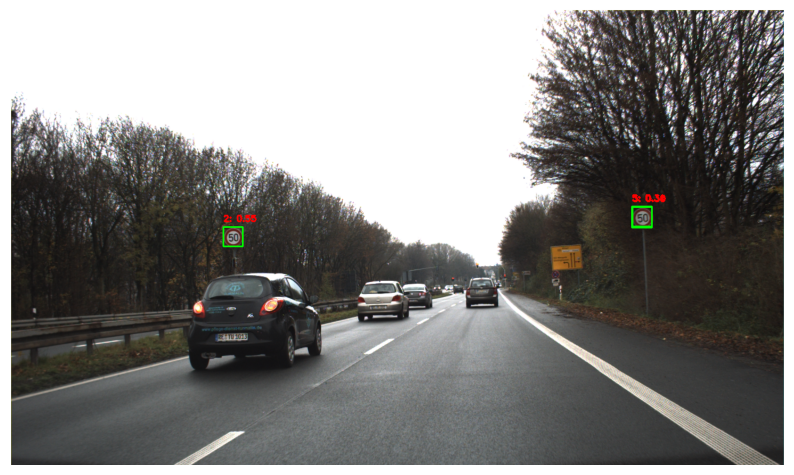

In [ ]:
# Test images directory
test_images_dir = "TestIJCNN2013Download"

# List all test images
test_images = [f for f in os.listdir(test_images_dir) if f.endswith('.ppm')]

# Visualize predictions for a few images
for i in range(10):  # Visualize first 5 images
    image_path = os.path.join(test_images_dir, test_images[i])
    print(f"Visualizing predictions for: {test_images[i]}")
    print()
    visualize_predictions(image_path, model, threshold=0.3)
    print()